Since some libraries arise error when pip-installed, all dependencies are included in the directory

In [13]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

from rlglue.rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env

Argmax : Takes in a list of action values and returns an action with the highest value. In the case of tie (same action valued indexes), tie is broken down with random index chose.

In [18]:
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index of the item 
    with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top_value = float("-inf") 
    ties = []
    
    for i in range(len(q_values)):
        if (q_values[i] > top_value):
            top_value = q_values[i]
            ties = [i]
            
        elif (q_values[i] == top_value):
            ties.append(i)

    return np.random.choice(ties)


agent_step : This method gets called each time the agent takes a step. The method has to return the action selected by the agent. This method also ensures the agent’s estimates are updated based on the signals it gets from the environment.



In [19]:
class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation=None):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step
        
        #######################
        
        # Update Q values : algorithm in section 2.4 of the textbook.
        # increment the counter in self.arm_count for the action from the previous time step
        # update the step size using self.arm_count
        # update self.q_values for the action from the previous time step
        
        
        current_action = argmax(self.q_values) #greedy move
        
        self.arm_count[self.last_action] += 1 #increment the arm count of that move
        
        step_size = 1/self.arm_count[self.last_action] 
        
        old_estimate = self.q_values[self.last_action]
        
        self.q_values[self.last_action] = old_estimate + step_size * (reward - old_estimate) # updates the estimate
    
        self.last_action = current_action
        
        return current_action
        

Experiment results running greedy agent : 

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 113.62it/s]


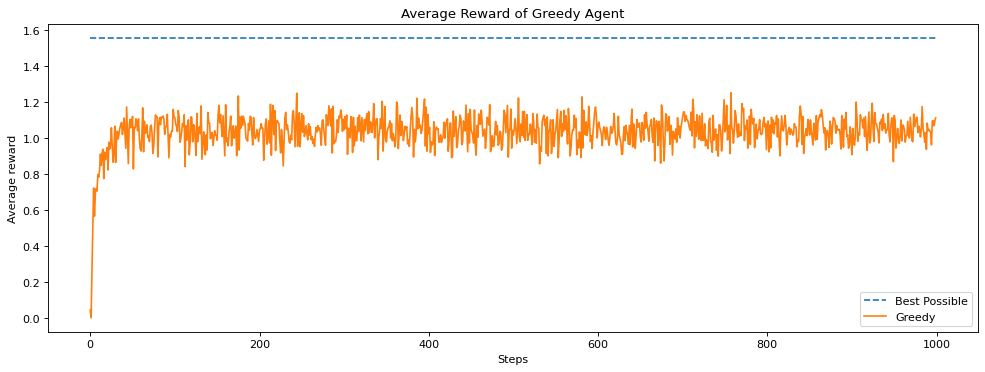

In [20]:
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of pulls of each arm the agent takes
env = ten_arm_env.Environment     # We set what environment we want to use to test
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # We pass the agent the information it needs. Here how many arms there are.
env_info = {}                     # We pass the environment the information it needs. In this case nothing.

rewards = np.zeros((num_runs, num_steps))
average_best = 0
for run in tqdm(range(num_runs)):           
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # We pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # We start the experiment

    average_best += np.max(rl_glue.environment.arms)
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        rewards[run, i] = reward

greedy_scores = np.mean(rewards, axis=0)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([average_best / num_runs for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Epsilon-Greedy Agent : Taking random actions on random basis, not-fully greedy

In [21]:
class EpsilonGreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Update Q values - this should be the same update as your greedy agent above
        # your code here
        
        
        # Choose action using epsilon greedy
        # Randomly choose a number between 0 and 1 and see if it's less than self.epsilon
        # If it is, set current_action to a random action.
        # otherwise choose current_action greedily as you did above.

        
        if(np.random.random() < self.epsilon):
            
            current_action = np.random.randint(0,len(self.q_values))
            
        else:
            
            current_action = argmax(self.q_values)
            
        self.arm_count[self.last_action] += 1
        
        step_size = 1 / self.arm_count[self.last_action]
        
        old_estimate = self.q_values[self.last_action]
        
        self.q_values[self.last_action] = old_estimate + step_size * (reward - old_estimate)
        
        self.last_action = current_action
        
        return current_action

Comparision b/ Greedy Agent and Epsilon Greedy Agent

100%|██████████████████████████████████████| 2000/2000 [00:17<00:00, 116.75it/s]


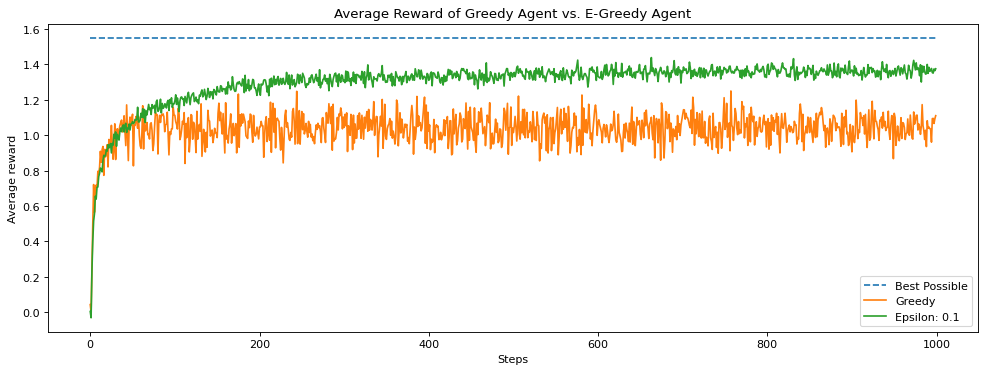

In [22]:
num_runs = 2000
num_steps = 1000
epsilon = 0.1
agent = EpsilonGreedyAgent
env = ten_arm_env.Environment
agent_info = {"num_actions": 10, "epsilon": epsilon}
env_info = {}
all_rewards = np.zeros((num_runs, num_steps))

for run in tqdm(range(num_runs)):
    np.random.seed(run)
    
    rl_glue = RLGlue(env, agent)
    rl_glue.rl_init(agent_info, env_info)
    rl_glue.rl_start()

    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        all_rewards[run, i] = reward

# take the mean over runs
scores = np.mean(all_rewards, axis=0)
plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(greedy_scores)
plt.title("Average Reward of Greedy Agent vs. E-Greedy Agent")
plt.plot(scores)
plt.legend(("Best Possible", "Greedy", "Epsilon: 0.1"))
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Different epsilon values will result in different average rewards through runs 

100%|████████████████████████████████████████| 200/200 [00:01<00:00, 140.03it/s]


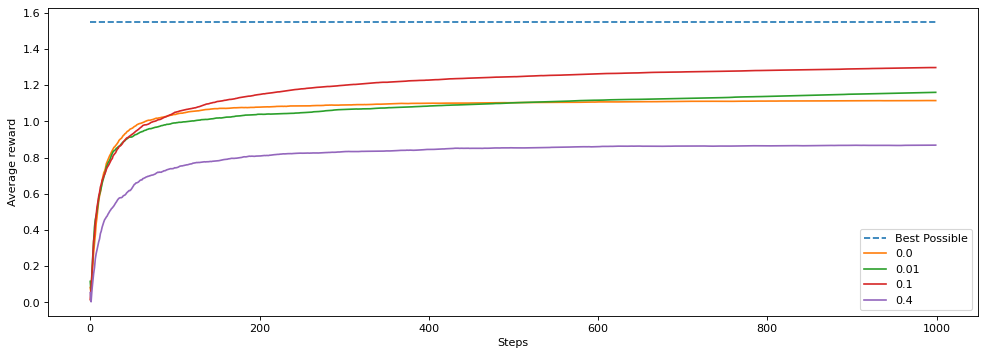

In [23]:
epsilons = [0.0, 0.01, 0.1, 0.4]

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

n_q_values = []
n_averages = []
n_best_actions = []

num_runs = 200

for epsilon in epsilons:
    all_averages = []
    for run in tqdm(range(num_runs)):
        agent = EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon}
        env_info = {"random_seed": run}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        scores = [0]
        averages = []
        best_action_chosen = []
        
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            scores.append(scores[-1] + reward)
            averages.append(scores[-1] / (i + 1))
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if epsilon == 0.1 and run == 0:
                n_q_values.append(np.copy(rl_glue.agent.q_values))
        if epsilon == 0.1:
            n_averages.append(averages)
            n_best_actions.append(best_action_chosen)
        all_averages.append(averages)
        
    plt.plot(np.mean(all_averages, axis=0))

plt.legend(["Best Possible"] + epsilons)
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Implementations of Greedy/Epsilon Greedy Agents involve non-constant step size parameter to update "Action Value Estimations", which is 1/N(A), where N(A) denotes number of times action A is taken : same as computing sample averages. 

In the case of non-stationary action value propbability distibutions, constant step size parameter leads to re-arrange of action-value estimation updates as follows : 

     new_estimate = old_estimate + self.step_size * (reward - old_estimate)

or when old estimate expressed recursively and step_size is distributed,

     new_estimate = pow((1-self.step_size),n) * first_estimate + ( self.step_size * pow((1-self.step_size), n-1)                                                  * reward-1 + self.step_size * pow((1-self.step_size), n-2) * reward-2 + ...) 
                        
which means, recent actions contributes more to the the action-value estimation. Also pay attention to the first_estimate and its coeficient. In every environment setting, although we might have a prior knowledge regarding the initial action-value estimations rather than just setting them to all zero, there might be "bias". Thus, this update rule reduces this initial bias with time by reducing first_estimate's coef. 

In [24]:
"""
Nothing fancy here, just changed epsilon greedy agent's action selection process with 
constant step size rather than average
"""
class EpsilonGreedyAgentConstantStepsize(main_agent.Agent): 
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent recieved from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this as you will not use it
                              until future lessons
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        
        ### Useful Class Variables ###
        # self.q_values : An array with what the agent believes each of the values of the arm are.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : An int of the action that the agent took on the previous time step.
        # self.step_size : A float which is the current step size for the agent.
        # self.epsilon : The probability an epsilon greedy agent will explore (ranges between 0 and 1)
        #######################
        
        # Update q_values for action taken at previous time step 
        # using self.step_size intead of using self.arm_count
        
        # Choose action using epsilon greedy. This is the same as you implemented above.
        # your code here
        
        if(np.random.random() < self.epsilon):
            
            current_action = np.random.randint(0,len(self.q_values))
            
        else:
            
            current_action = argmax(self.q_values)
            
        self.arm_count[self.last_action] += 1
        
        old_estimate = self.q_values[self.last_action]
        
        self.q_values[self.last_action] = old_estimate + self.step_size * (reward - old_estimate)
                
        
        self.last_action = current_action
        
        return current_action

Comparing all 3 approaches : 


Remark - the plot is % Best Arm Pulled vs Steps, not Average Reward vs Steps. 


100%|████████████████████████████████████████| 200/200 [00:01<00:00, 113.78it/s]
/tmp/ipykernel_12965/3358721971.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])


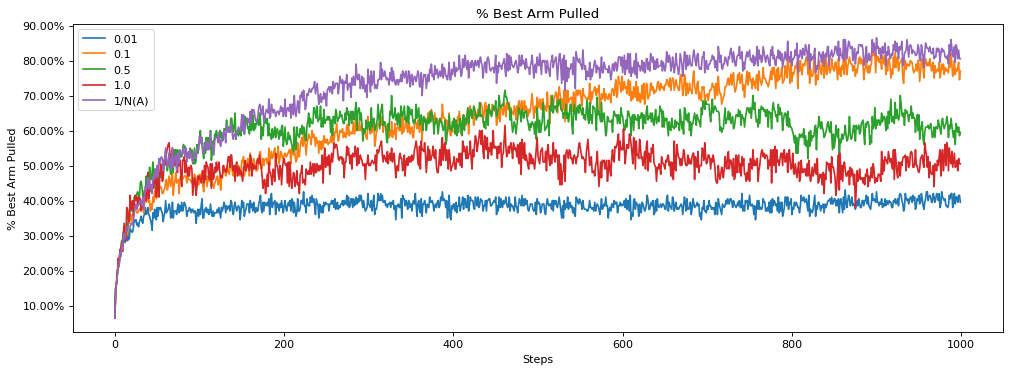

In [25]:
# Experiment code for different step sizes
step_sizes = [0.01, 0.1, 0.5, 1.0, '1/N(A)']

epsilon = 0.1
num_steps = 1000
num_runs = 200

fig, ax = plt.subplots(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')

q_values = {step_size: [] for step_size in step_sizes}
true_values = {step_size: None for step_size in step_sizes}
best_actions = {step_size: [] for step_size in step_sizes}

for step_size in step_sizes:
    all_averages = []
    for run in tqdm(range(num_runs)):
        np.random.seed(run)
        agent = EpsilonGreedyAgentConstantStepsize if step_size != '1/N(A)' else EpsilonGreedyAgent
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size, "initial_value": 0.0}
        env_info = {}

        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()
        
        best_arm = np.argmax(rl_glue.environment.arms)

        if run == 0:
            true_values[step_size] = np.copy(rl_glue.environment.arms)
            
        best_action_chosen = []
        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            if action == best_arm:
                best_action_chosen.append(1)
            else:
                best_action_chosen.append(0)
            if run == 0:
                q_values[step_size].append(np.copy(rl_glue.agent.q_values))
        best_actions[step_size].append(best_action_chosen)
    ax.plot(np.mean(best_actions[step_size], axis=0))

plt.legend(step_sizes)
plt.title("% Best Arm Pulled")
plt.xlabel("Steps")
plt.ylabel("% Best Arm Pulled")
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
plt.show()

Notice that overall step size of 1/N(A) results in more best actions to be taken 

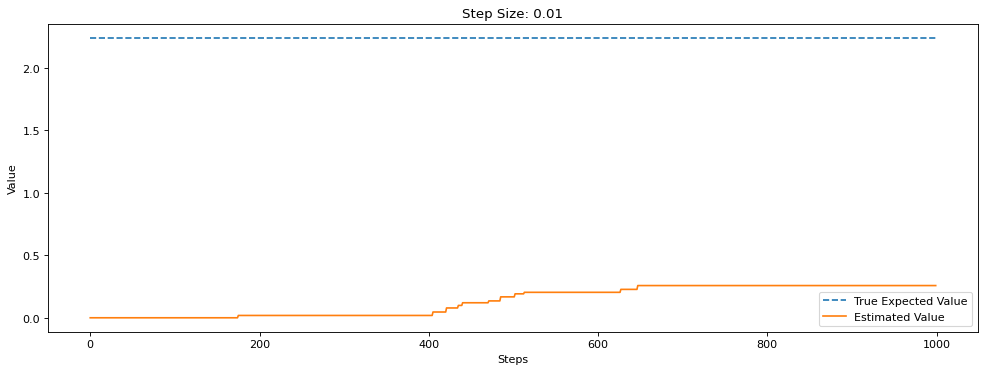

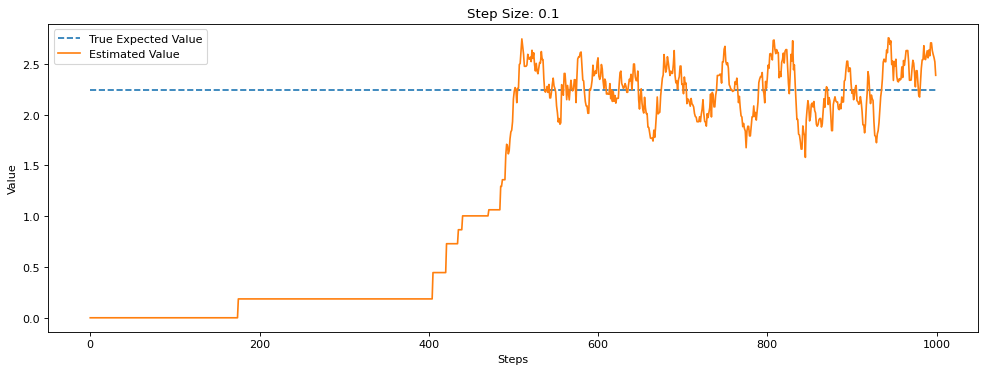

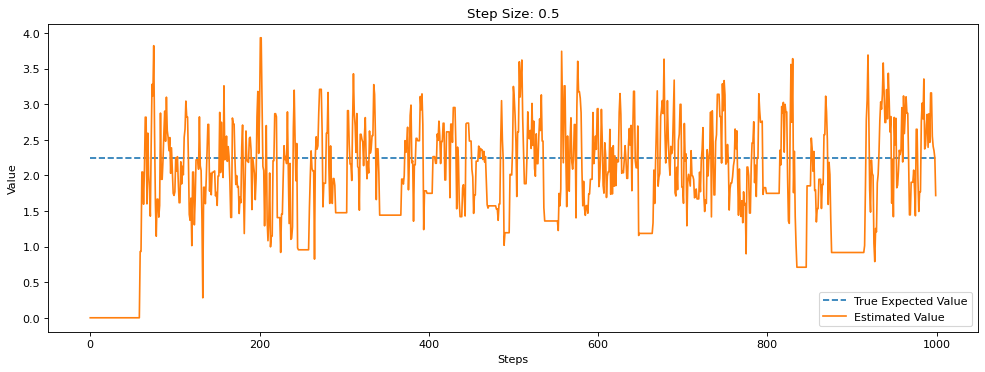

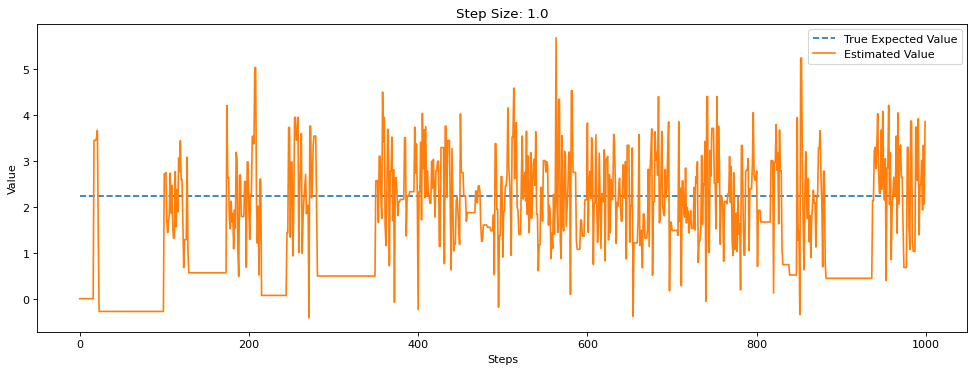

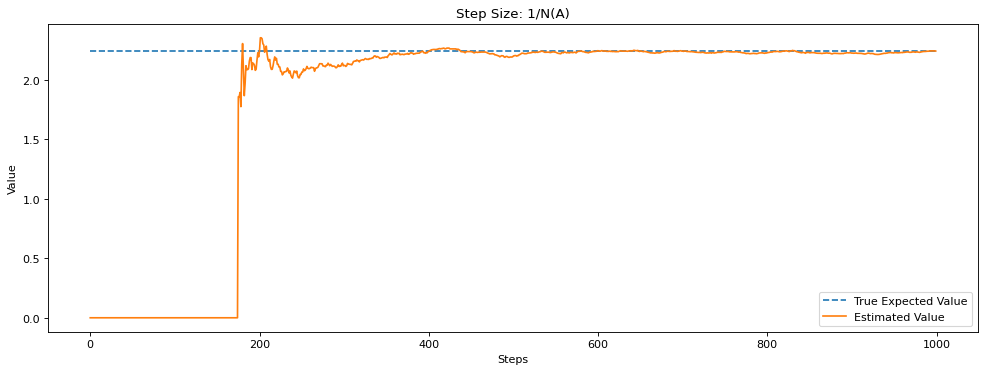

In [26]:
largest = 0
num_steps = 1000
for step_size in step_sizes:
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size])
    plt.plot([true_values[step_size][largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(step_size))
    plt.plot(np.array(q_values[step_size])[:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()

A step size of 0.01 makes such small updates that the agent’s value estimate of the best action does not get close to the actual value. Step sizes of 0.5 and 1.0 both get close to the true value quickly, but are very susceptible to stochasticity in the rewards. The updates overcorrect too much towards recent rewards, and so oscillate around the true value. This means that on many steps, the action that pulls the best arm may seem worse than it actually is. A step size of 0.1 updates fairly quickly to the true value, and does not oscillate as widely around the true values as 0.5 and 1.0. This is one of the reasons that 0.1 performs quite well. Finally we see why 1/N(A) performed well. Early on while the step size is still reasonably high it moves quickly to the true expected value, but as it gets pulled more its step size is reduced which makes it less susceptible to the stochasticity of the rewards.

However, non-constant step size 1/N(A) will no perform well in non-stationary problems as stated above. In non-stationary environments, action-values are changing on regular basis; thus, action-value estimations cannot converge to a action-value. Thus, constant step size is a solution to prioriatize recent action-rewards to update action-value estimates.

100%|█████████████████████████████████████████| 500/500 [00:08<00:00, 58.43it/s]


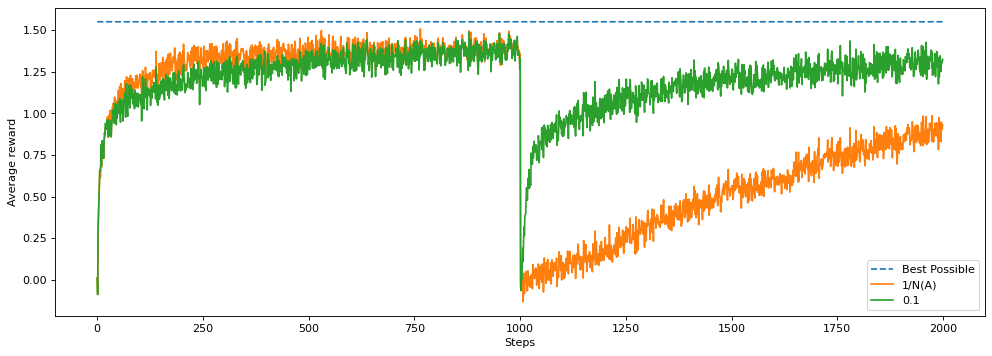

In [28]:
epsilon = 0.1
num_steps = 2000
num_runs = 500
step_size = 0.1

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")

for agent in [EpsilonGreedyAgent, EpsilonGreedyAgentConstantStepsize]:
    rewards = np.zeros((num_runs, num_steps))
    for run in tqdm(range(num_runs)):
        agent_info = {"num_actions": 10, "epsilon": epsilon, "step_size": step_size}
        np.random.seed(run)
        
        rl_glue = RLGlue(env, agent)
        rl_glue.rl_init(agent_info, env_info)
        rl_glue.rl_start()

        for i in range(num_steps):
            reward, state, action, is_terminal = rl_glue.rl_step()
            rewards[run, i] = reward
            if i == 1000:
                rl_glue.environment.arms = np.random.randn(10)
        
    plt.plot(np.mean(rewards, axis=0))
plt.legend(["Best Possible", "1/N(A)", "0.1"])
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()

Textbook Note : Now the agent with a step size of 1/N(A) performed better at the start but then performed worse when the environment changed! What happened?
Think about what the step size would be after 1000 steps. Let's say the best action gets chosen 500 times. That means the step size for that action is 1/500 or 0.002. At each step when we update the value of the action and the value is going to move only 0.002 * the error. That is a very tiny adjustment and it will take a long time for it to get to the true value.
The agent with step size 0.1, however, will always update in 1/10th of the direction of the error. This means that on average it will take ten steps for it to update its value to the sample mean.
These are the types of tradeoffs we have to think about in reinforcement learning. A larger step size moves us more quickly toward the true value, but can make our estimated values oscillate around the expected value. A step size that reduces over time can converge to close to the expected value, without oscillating. On the other hand, such a decaying stepsize is not able to adapt to changes in the environment. Nonstationarity---and the related concept of partial observability---is a common feature of reinforcement learning problems and when learning online.